In [1]:
import sys
from ezr import *

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os

config_folder = 'data/optimize/config'
datasets = [os.path.join(config_folder, file) for file in os.listdir(config_folder) if file.endswith('.csv')]

In [3]:
import random

def activeLearning(self: DATA, score=lambda B, R: B - R, generate=None, faster=True):
    def ranked(rows):
        return self.clone(rows).distances().rows

    def todos(todo):
        if faster:  # Apply sorting heuristics to a small buffer at the start of "todo"
            n = the.buffer // 2
            return todo[:n] + todo[2 * n: 3 * n], todo[3 * n:] + todo[n:2 * n]
        else:  # Apply sorting heuristics to all of "todo"
            return todo, []

    def guess(todo: rows, done: rows) -> rows:
        cut = int(.5 + len(done) ** the.cut)
        best = self.clone(done[:cut])
        rest = self.clone(done[cut:])
        a, b = todos(todo)
        if generate:
            return self.neighbors(generate(best, rest), a) + b
        else:
            key = lambda r: score(best.loglike(r, len(done), 2), rest.loglike(r, len(done), 2))
            return sorted(a, key=key, reverse=True) + b

    def guess_all(todo: rows, done: rows) -> rows:
        cut = int(.5 + len(done) ** the.cut)
        best = self.clone(done[:cut])
        rest = self.clone(done[cut:])
        key = lambda r: best.loglike(r, len(done), 2)
        return sorted(todo, key=key, reverse=True)

    def loop(todo: rows, done: rows) -> rows:
        while len(todo) > 2 and len(done) < the.Last:
            top, *todo = guess(todo, done)
            done += [top]
            done = ranked(done)
            the.iter += 1
        result = model_ranking(todo, done)
        return done, result

    todo, done = self.rows[the.label:], ranked(self.rows[:the.label])

    if the.branch == True:
        todo, done = self.branch(used=[])
        if the.Last == 0: return done

    def model_ranking(todo, done):
        # Determine the cutoff for the best subset
        cut = int(0.5 + len(done) ** the.cut)
        best = self.clone(done[:cut])  # Select the best subset
        rest = self.clone(done[cut:])  # The remaining rows
        
        # Generate 1000 random pairs
        random_pairs = [(random.choice(d.rows), random.choice(d.rows)) for _ in range(1000)]
        
        correct_guesses = 0
        
        for row1, row2 in random_pairs:
            # Use loglike to guess which row has a higher y value
            guess = row1 if best.loglike(row1, len(done), 2) > best.loglike(row2, len(done), 2) else row2
            
            # Find true y values using d.distance(row)
            true_higher = row1 if d.distance(row1) < d.distance(row2) else row2
            
            # Check if the guess is correct
            if guess == true_higher:
                correct_guesses += 1
        
        return correct_guesses

    the.iter = 0
    return loop(todo, done)

scoring_policies = [('certain', lambda B, R,: exp(B) ** 2 / (1E-30 + exp(R))),
                    ('uncertain', lambda B, R :  (exp(B) + exp(R))/ (1E-30 + abs(exp(B) - exp(R)))),
                    ('random',  lambda B, R : random.random()),
                    ('FOCUS', lambda B, R: ((exp(B) + 1) ** normalized_exp(the.iter, the.Last, 1) + (exp(R) + 1)) / (abs(exp(B) - exp(R)) + 10**-30))]

data/All/rs-6d-c3_obj2.csv
data/All/xomo_ground.csv
data/All/sol-6d-c2-obj1.csv
data/All/wc+wc-3d-c4-obj1.csv
data/All/rs-6d-c3_obj1.csv
data/All/Apache_AllMeasurements.csv
data/All/nasa93dem.csv
data/All/HSMGP_num.csv
data/All/healthCloseIsses12mths0001-hard.csv
data/All/wc+rs-3d-c4-obj1.csv
data/All/SQL_AllMeasurements.csv
data/All/SS-H.csv
data/All/SS-I.csv
data/All/SS-K.csv
data/All/SS-J.csv
data/All/wc-6d-c1-obj1.csv
data/All/auto93.csv
data/All/SS-N.csv
data/All/SS-O.csv
data/All/SS-X.csv
data/All/SS-M.csv
data/All/healthCloseIsses12mths0011-easy.csv
data/All/SS-L.csv
data/All/SS-V.csv
data/All/SS-A.csv
data/All/SS-W.csv
data/All/SS-U.csv
data/All/SS-B.csv
data/All/xomo_osp2.csv
data/All/SS-C.csv
data/All/SS-T.csv
data/All/coc1000.csv
data/All/SS-G.csv
data/All/SS-P.csv
data/All/xomo_osp.csv
data/All/SS-Q.csv
data/All/SS-F.csv
data/All/X264_AllMeasurements.csv
data/All/SS-D.csv
data/All/SS-S.csv
data/All/SS-R.csv
data/All/SS-E.csv
data/All/pom3b.csv
data/All/pom3c.csv
data/All/xo

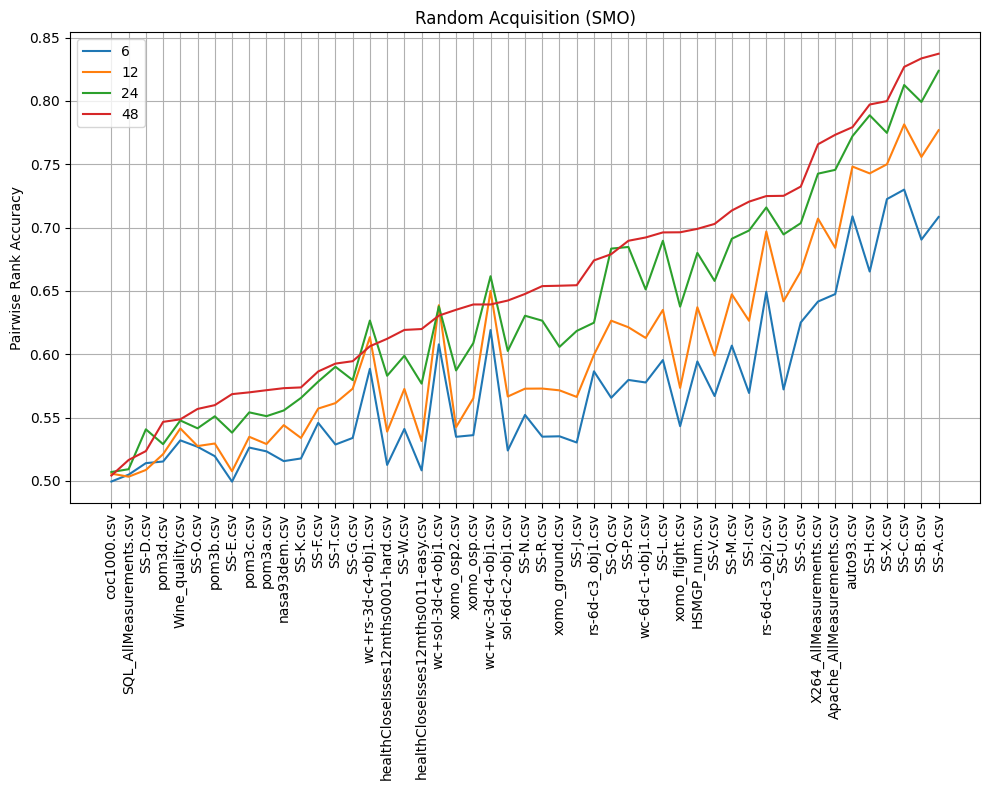

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Load dataset and initialize
folder = 'data/All'
datasets = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.csv')]
dataset_names = [os.path.basename(file) for file in datasets]

scoring_policies = [('random', lambda B, R: random.random())]

scores = {6: [], 12: [], 24: [], 48: []}

for dataset in datasets:
    print(dataset)
    d = DATA().adds(csv(dataset))
    for what, how in scoring_policies:
        for the.Last in [6, 12, 24, 48]:
            results = []
            
            for trial in range(100):
                random.shuffle(d.rows)
                done, result = activeLearning(d, how)
                results.append(result)
        
            score = np.round(sum(results) / len(results) / 1000, 4)
            scores[the.Last].append(score)

# Sorting the scores for the row with '48'
order = np.argsort(scores[48])

# Sorting all score lists based on the order derived from '48'
sorted_scores = {k: np.array(v)[order] for k, v in scores.items()}
sorted_dataset_names = np.array(dataset_names)[order]  # Sort dataset names similarly

# Plotting the scores
plt.figure(figsize=(10, 8))

for key, values in sorted_scores.items():
    plt.plot(values, label=f'{key}')

# Adding tick marks at the bottom with dataset names
plt.xticks(ticks=np.arange(len(datasets)), labels=sorted_dataset_names, rotation=90)

# Adding y-axis label
plt.ylabel('Pairwise Rank Accuracy')

plt.title('Random Acquisition (SMO)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

data/All/rs-6d-c3_obj2.csv
data/All/xomo_ground.csv
data/All/sol-6d-c2-obj1.csv
data/All/wc+wc-3d-c4-obj1.csv
data/All/rs-6d-c3_obj1.csv
data/All/Apache_AllMeasurements.csv
data/All/nasa93dem.csv
data/All/HSMGP_num.csv
data/All/healthCloseIsses12mths0001-hard.csv
data/All/wc+rs-3d-c4-obj1.csv
data/All/SQL_AllMeasurements.csv
data/All/SS-H.csv
data/All/SS-I.csv
data/All/SS-K.csv
data/All/SS-J.csv
data/All/wc-6d-c1-obj1.csv
data/All/auto93.csv
data/All/SS-N.csv
data/All/SS-O.csv
data/All/SS-X.csv
data/All/SS-M.csv
data/All/healthCloseIsses12mths0011-easy.csv
data/All/SS-L.csv
data/All/SS-V.csv
data/All/SS-A.csv
data/All/SS-W.csv
data/All/SS-U.csv
data/All/SS-B.csv
data/All/xomo_osp2.csv
data/All/SS-C.csv
data/All/SS-T.csv
data/All/coc1000.csv
data/All/SS-G.csv
data/All/SS-P.csv
data/All/xomo_osp.csv
data/All/SS-Q.csv
data/All/SS-F.csv
data/All/X264_AllMeasurements.csv
data/All/SS-D.csv
data/All/SS-S.csv
data/All/SS-R.csv
data/All/SS-E.csv
data/All/pom3b.csv
data/All/pom3c.csv
data/All/xo

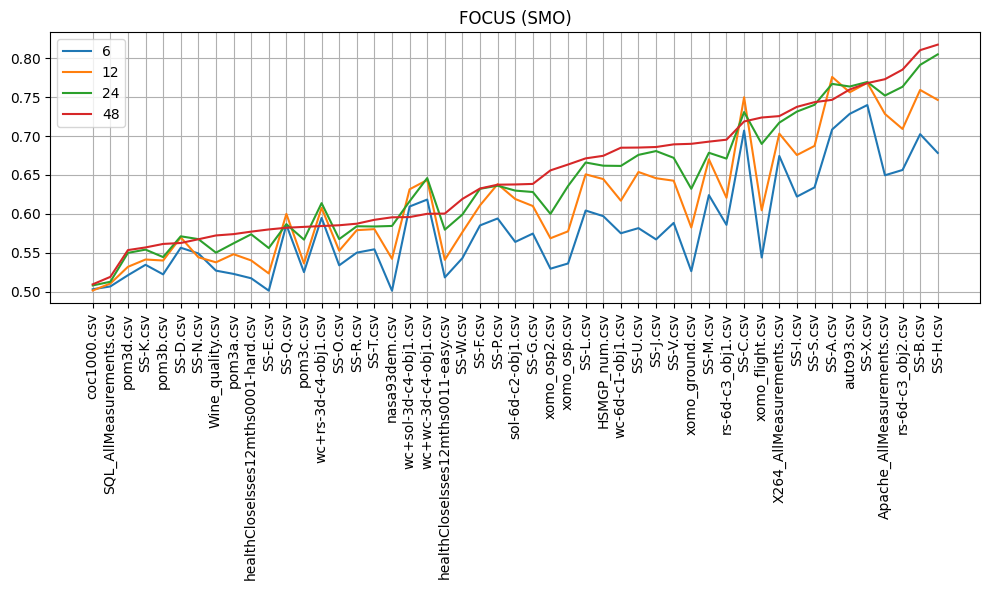

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Load dataset and initialize
folder = 'data/All'
datasets = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.csv')]
dataset_names = [os.path.basename(file) for file in datasets]

scoring_policies = [('FOCUS', lambda B, R: ((exp(B) + 1) ** normalized_exp(the.iter, the.Last, 1) + (exp(R) + 1)) / (abs(exp(B) - exp(R)) + 10**-30))]

scores = {6: [], 12: [], 24: [], 48: []}

for dataset in datasets:
    print(dataset)
    d = DATA().adds(csv(dataset))
    for what, how in scoring_policies:
        for the.Last in [6, 12, 24, 48]:
            results = []
            
            for trial in range(100):
                random.shuffle(d.rows)
                done, result = activeLearning(d, how)
                results.append(result)
        
            score = np.round(sum(results) / len(results) / 1000, 4)
            scores[the.Last].append(score)

# Sorting the scores for the row with '48'
order = np.argsort(scores[48])

# Sorting all score lists based on the order derived from '48'
sorted_scores = {k: np.array(v)[order] for k, v in scores.items()}
sorted_dataset_names = np.array(dataset_names)[order]  # Sort dataset names similarly

# Plotting the scores
plt.figure(figsize=(10, 6))

for key, values in sorted_scores.items():
    plt.plot(values, label=f'{key}')

# Adding tick marks at the bottom with dataset names
plt.xticks(ticks=np.arange(len(datasets)), labels=sorted_dataset_names, rotation=90)

plt.title('FOCUS (SMO)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import fmin_l_bfgs_b
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Predicted variances smaller than 0. Setting those variances to 0.")

# Define the UCB_GPM function
def UCB_GPM(d, todo, done):
    the.iter = 0
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1.0, (1e-8, 1e8))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    num_indexes = [col.at for col in d.cols.x if type(col) == NUM]
    sym_indexes = [col.at for col in d.cols.x if type(col) == SYM]

    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_indexes),
            ('cat', cat_transformer, sym_indexes)])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    if sym_indexes:
        cat_data = np.array([[str(row[idx]) for idx in sym_indexes] for row in done], dtype=object)
        cat_transformer.fit(cat_data)
    
    def custom_optimizer(obj_func, initial_theta, bounds):
        theta_opt, func_min, _ = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxiter=1000)
        return theta_opt, func_min
    
    gp.optimizer = custom_optimizer

    def update_gp_model(done_set):
        X_done = np.array([x for x in done_set], dtype=object)
        y_done = np.array([-d.distance(x) for x in done_set])
        X_done_transformed = pipeline.fit_transform(X_done)
        gp.fit(X_done_transformed, y_done)
    
    def ucb(x, kappa=2.576):
        x = np.array(x).reshape(1, -1).astype(object)
        x_transformed = pipeline.transform(x)
        mean, std = gp.predict(x_transformed, return_std=True)
        return mean + kappa * std

    def _mean(x):
        x = np.array(x).reshape(1, -1).astype(object)
        x_transformed = pipeline.transform(x)
        mean, std = gp.predict(x_transformed, return_std=True)
        return mean

    def _ranked(rows):
        return d.clone(rows).distances().rows

    def model_ranking(todo, done):
        random_pairs = [(random.choice(d.rows), random.choice(d.rows)) for _ in range(100)]
        correct_guesses = 0
        
        for row1, row2 in random_pairs:
            guess = row1 if _mean(row1) > _mean(row2) else row2
            true_higher = row1 if d.distance(row1) < d.distance(row2) else row2
            if guess == true_higher:
                correct_guesses += 1
        
        return correct_guesses

    while todo and len(done) < the.Last:
        update_gp_model(done)
        random.shuffle(todo)
        todo_subset = todo[:the.buffer]

        ucb_values = [ucb(row) for row in todo_subset]
        best_idx = np.argmax(ucb_values)
        best_candidate = todo.pop(best_idx)
         
        done.append(best_candidate)
        the.iter += 1

    result = model_ranking(todo, done)
    
    return done, result

data/All/rs-6d-c3_obj2.csv
data/All/xomo_ground.csv
data/All/sol-6d-c2-obj1.csv
data/All/wc+wc-3d-c4-obj1.csv
data/All/rs-6d-c3_obj1.csv
data/All/Apache_AllMeasurements.csv
data/All/nasa93dem.csv
data/All/HSMGP_num.csv
data/All/healthCloseIsses12mths0001-hard.csv
data/All/wc+rs-3d-c4-obj1.csv
data/All/SQL_AllMeasurements.csv
data/All/SS-H.csv
data/All/SS-I.csv
data/All/SS-K.csv
data/All/SS-J.csv
data/All/wc-6d-c1-obj1.csv
data/All/auto93.csv
data/All/SS-N.csv
data/All/SS-O.csv
data/All/SS-X.csv
data/All/SS-M.csv
data/All/healthCloseIsses12mths0011-easy.csv
data/All/SS-L.csv
data/All/SS-V.csv
data/All/SS-A.csv
data/All/SS-W.csv
data/All/SS-U.csv
data/All/SS-B.csv
data/All/xomo_osp2.csv
data/All/SS-C.csv
data/All/SS-T.csv
data/All/coc1000.csv
data/All/SS-G.csv
data/All/SS-P.csv
data/All/xomo_osp.csv
data/All/SS-Q.csv
data/All/SS-F.csv
data/All/X264_AllMeasurements.csv
data/All/SS-D.csv
data/All/SS-S.csv
data/All/SS-R.csv
data/All/SS-E.csv
data/All/pom3b.csv
data/All/pom3c.csv
data/All/xo

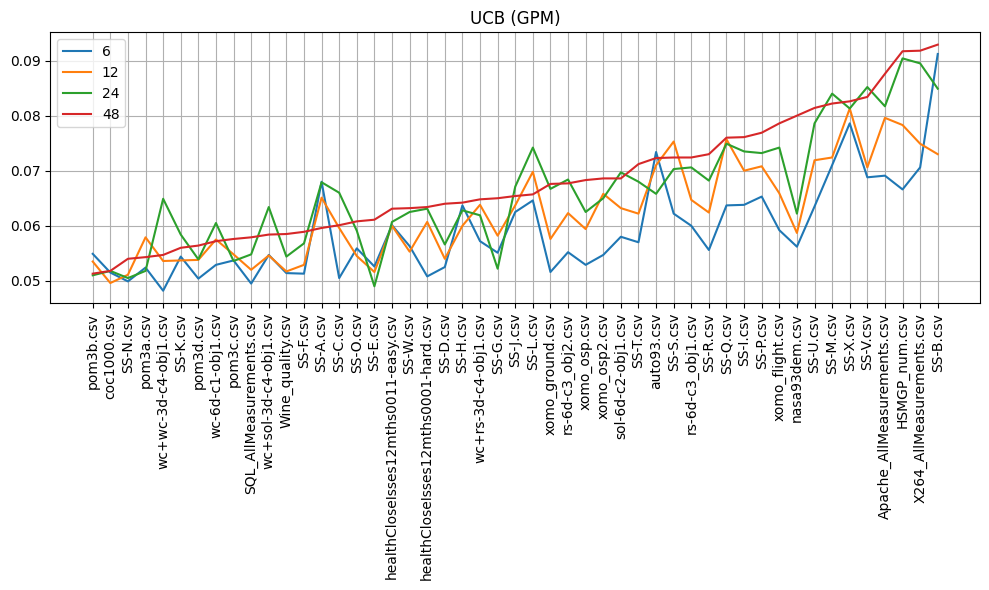

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Load dataset and initialize
folder = 'data/All'
datasets = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.csv')]
dataset_names = [os.path.basename(file) for file in datasets]

scoring_policies = [('UCB_GPM', 'UCB_GPM')]

scores = {6: [], 12: [], 24: [], 48: []}

for dataset in datasets:
    print(dataset)
    d = DATA().adds(csv(dataset))
    for what, how in scoring_policies:
        for the.Last in [6, 12, 24, 48]:
            results = []
            
            for trial in range(10):
                random.shuffle(d.rows)
                todo, done = d.rows[the.label:], (d.rows[:the.label])
                done, result = UCB_GPM(d, todo, done)
                results.append(result)
        
            score = np.round(sum(results) / len(results) / 1000, 4)
            scores[the.Last].append(score)

# Sorting the scores for the row with '48'
order = np.argsort(scores[48])

# Sorting all score lists based on the order derived from '48'
sorted_scores = {k: np.array(v)[order] for k, v in scores.items()}
sorted_dataset_names = np.array(dataset_names)[order]  # Sort dataset names similarly

# Plotting the scores
plt.figure(figsize=(10, 6))

for key, values in sorted_scores.items():
    plt.plot(values, label=f'{key}')

# Adding tick marks at the bottom with dataset names
plt.xticks(ticks=np.arange(len(datasets)), labels=sorted_dataset_names, rotation=90)

plt.title('UCB (GPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()